# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the Files

Download the csv files into the `data/` directory.

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}\n")

Train shape: (370703, 24)
Test shape: (92676, 23)



# Adding Features

In [3]:
def feature_engineering(df, encoders=None, fit_encoders=False):
    # Extract time-based features
    df['hour'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S').dt.hour
    df['day_of_week'] = pd.to_datetime(df['trans_date']).dt.dayofweek
    df['age'] = pd.Timestamp('now').year - pd.to_datetime(df['dob']).dt.year

    # Calculate distance between cardholder and merchant
    df['distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

    # amt_per_capita: transaction amount relative to city population
    df['amt_per_capita'] = df['amt'] / (df['city_pop'] + 1)

    # Transaction velocity: Count transactions per user in a rolling time window
    df['trans_count'] = df.groupby('cc_num')['unix_time'].transform(lambda x: x.rolling(window=3).count())

    # Spending ratio: Compare transaction amount with the user’s mean spending
    df['amt_ratio'] = df['amt'] / df.groupby('cc_num')['amt'].transform('mean')

    # Encode categorical variables
    cat_cols = ['category', 'gender', 'job', 'state', 'city', 'merchant']
    if fit_encoders:
        encoders = {}
        ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df[cat_cols] = ordinal_encoder.fit_transform(df[cat_cols])
        encoders['ordinal_encoder'] = ordinal_encoder
    else:
        ordinal_encoder = encoders['ordinal_encoder']
        df[cat_cols] = ordinal_encoder.transform(df[cat_cols])

    # Drop unused columns
    df.drop(columns=['trans_date', 'trans_time', 'dob', 'first', 'last', 'street'], inplace=True)
    return df, encoders

# Sample + Split into training and testing set

In [4]:
train, encoders = feature_engineering(train, fit_encoders=True)
test, _ = feature_engineering(test, encoders=encoders, fit_encoders=False)

# Feature Selection

In [5]:
X = train.drop(columns=['is_fraud', 'trans_num', 'id'])
y = train['is_fraud']
X_test_submission = test.drop(columns=['trans_num', 'id'])

##################################
# Handle Class Imbalance with SMOTE
##################################
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Scale numeric features
numeric_features = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop', 'amt_per_capita', 'age', 'hour', 'distance']
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test_submission[numeric_features] = scaler.transform(X_test_submission[numeric_features])

# Model Creation

In [6]:
model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

##################################
# Model Evaluation
##################################
y_pred = model.predict(X_val)
print("F1-Score on Validation Set:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

F1-Score on Validation Set: 0.9916369440859065

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     65681
           1       0.99      0.99      0.99     65681

    accuracy                           0.99    131362
   macro avg       0.99      0.99      0.99    131362
weighted avg       0.99      0.99      0.99    131362



# Model Evaluation

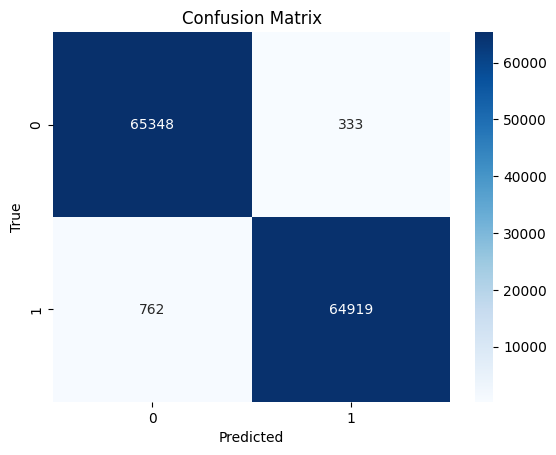

In [7]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Create submission file

In [8]:
y_test_pred = model.predict(X_test_submission)
test['is_fraud'] = y_test_pred

# Save submission file
submission = test[['id', 'is_fraud']]
submission.to_csv('./data/fraud_submission2.csv', index=False)
print("Submission file created: fraud_submission2.csv")

Submission file created: fraud_submission.csv
